# NL COVID 19 data exploration

- data from https://data.rivm.nl/covid-19/
- taken 2021-03-18

## Notes

- Given that daily reported numbers are in small quantities
(i.e. <100), changes represented in % changes
can be highly sensitive.
E.g. Changing from 1 to 5 is a 500% change.
- But % change is the only way to
compare change in qty across different slices
of data.
- So take those figures with a pinch of salt.
- That being said, we are looking for anomalies,
so a sufficiently large % change would signal
an abnormally large change.

In [15]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import typing

plt.rcParams["figure.figsize"] = (20,15)
_FONTSIZE=20

# Initial data management
_DATADIR="_data"
_DATA_CUMUL="COVID-19_aantallen_gemeente_cumulatief-2021-03-18.csv"
cumul = pd.read_csv(os.path.join(_DATADIR, _DATA_CUMUL), delimiter=";")
cumul["Date_of_report"] = pd.to_datetime(cumul["Date_of_report"]) # set dtype of "Date_of_report" to pd.DatetimeTZDtype
cumul["Date_of_report"] = cumul["Date_of_report"].dt.normalize() # get date portion of datetime only
cumul.sort_values(by="Date_of_report",ascending=True,inplace=True)

 # Get only cases from Amsterdam:
cumul_ams = cumul[cumul["Municipality_name"].isin(["Amsterdam"])]

# compare day on day increments/deltas
def get_daily_delta(df: pd.DataFrame, col: str) -> typing.List[int]:
    """
    Returns list containing daily reported cases
    """
    daily_delta_column = []
    reported = df[col]
    for i in range(0,len(reported)):
        if i == 0:
            daily_delta_column.append(0)
            continue # skip this index
        daily_delta_column.append(
            reported.iloc[i]-reported.iloc[i-1]
        )

    return daily_delta_column

cumul_ams.insert(len(cumul_ams.columns), "Day",cumul_ams["Date_of_report"].dt.day_name()) # create new column for day of week
cumul_ams["Day"].astype("str")
cumul_ams.insert(len(cumul_ams.columns), "Week", cumul_ams["Date_of_report"].dt.week) # create new column for week number
cumul_ams.insert(len(cumul_ams.columns),"Daily_delta",get_daily_delta(cumul_ams, "Total_reported")) # add daily delta of total reported to df
cumul_ams.insert(len(cumul_ams.columns),"Deceased_delta",get_daily_delta(cumul_ams, "Deceased")) # add daily delta of total deceased to df
cumul_ams.insert(len(cumul_ams.columns),"Hospital_delta",get_daily_delta(cumul_ams, "Hospital_admission")) # add daily delta of total hospitalized to df

<ipython-input-15-b0b9e8d85a40>:41: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  cumul_ams.insert(len(cumul_ams.columns), "Week", cumul_ams["Date_of_report"].dt.week) # create new column for week number


### Get only the data we want from dataframe

In [2]:
# create working df with: date, cumulative day of week, week number, reports
cumuldf = cumul_ams[
    ["Date_of_report","Day","Week","Daily_delta", "Total_reported", "Deceased", "Deceased_delta", "Hospital_admission", "Hospital_delta"]
]
cumuldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 371 entries, 109 to 135686
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date_of_report      371 non-null    datetime64[ns]
 1   Day                 371 non-null    object        
 2   Week                371 non-null    int64         
 3   Daily_delta         371 non-null    int64         
 4   Total_reported      371 non-null    int64         
 5   Deceased            371 non-null    int64         
 6   Deceased_delta      371 non-null    int64         
 7   Hospital_admission  371 non-null    int64         
 8   Hospital_delta      371 non-null    int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 29.0+ KB


### Data from last 10 days

In [3]:
cumuldf.tail(10)

,Date_of_report,Day,Week,Daily_delta,Total_reported,Deceased,Deceased_delta,Hospital_admission,Hospital_delta
132410,2021-03-09,Tuesday,10,215,65040,690,3,1613,4
132774,2021-03-10,Wednesday,10,232,65272,691,1,1616,3
133138,2021-03-11,Thursday,10,248,65520,694,3,1619,3
133502,2021-03-12,Friday,10,325,65845,696,2,1622,3
133866,2021-03-13,Saturday,10,217,66062,698,2,1628,6
134230,2021-03-14,Sunday,10,270,66332,700,2,1634,6
134594,2021-03-15,Monday,11,163,66495,702,2,1634,0
134958,2021-03-16,Tuesday,11,263,66758,702,0,1640,6
135322,2021-03-17,Wednesday,11,260,67018,704,2,1641,1
135686,2021-03-18,Thursday,11,181,67199,704,0,1647,6


### Top 10 days (reported cases)

In [4]:
sorted_df = cumuldf[["Date_of_report","Week","Daily_delta","Total_reported","Hospital_delta"]].sort_values(by="Daily_delta",ascending=False)
sorted_df.head(10)

,Date_of_report,Week,Daily_delta,Total_reported,Hospital_delta
83051,2020-10-25,43,831,27273,8
81950,2020-10-22,43,813,25191,14
81583,2020-10-21,43,751,24378,7
82317,2020-10-23,43,745,25936,14
78647,2020-10-13,42,734,19163,16
80482,2020-10-18,42,726,22398,7
81216,2020-10-20,43,696,23627,3
80115,2020-10-17,42,687,21672,19
83785,2020-10-27,44,686,28485,6
79748,2020-10-16,42,682,20985,7


In [5]:
def get_week_start_end(df:pd.DataFrame, week_number:int)->typing.Tuple[str,str]:
    """
    Returns a tuple of (week_start, week_end),
    that are two strings:
    - week_start is the start date of a week (i.e. dd/mm on that monday)
    - week_end is the end date of a week (i.e. dd/mm on that sunday)
    """
    df_week = df["Week"]
    # this_week = df[df_week == df_week.max()-week_number]
    this_week = df[df_week == week_number]
    week_start = this_week.iloc[0]["Date_of_report"]
    week_start_d_m = f"{week_start.day}/{week_start.month}"
    week_end = this_week.iloc[-1]["Date_of_report"]
    week_end_d_m = f"{week_end.day}/{week_end.month}"
    return week_start_d_m, week_end_d_m


def plot_daily_delta_for_last_n_weeks(df:pd.DataFrame, n:int=3):
    """
    Plots n number of weeks
    worth of daily deltas in one line chart
    """
    plt.grid(True)
    plt.xticks(rotation="vertical", fontsize=_FONTSIZE)
    plt.xlabel("Day of week", fontsize=_FONTSIZE)
    plt.yticks(np.arange(0, df["Daily_delta"].max(), step=5), fontsize=_FONTSIZE)
    plt.ylabel("Daily change", fontsize=_FONTSIZE)

    for week in range(0,n):
        this_week_number = df["Week"].max() - week
        this_week = df[df["Week"] == this_week_number]
        last_week = df[df["Week"] == this_week_number-1]

        x_range = ["(Sunday before)"]+this_week["Day"].to_list()
        including_last_sunday = [last_week["Daily_delta"].to_list()[-1]]+this_week["Daily_delta"].to_list()
        week_start_d_m, week_end_d_m = get_week_start_end(df,this_week_number)

        plt.plot(x_range,including_last_sunday,label=f"{week_start_d_m} – {week_end_d_m}")
    plt.legend(fontsize=_FONTSIZE)

### Plot daily reported cases, by week

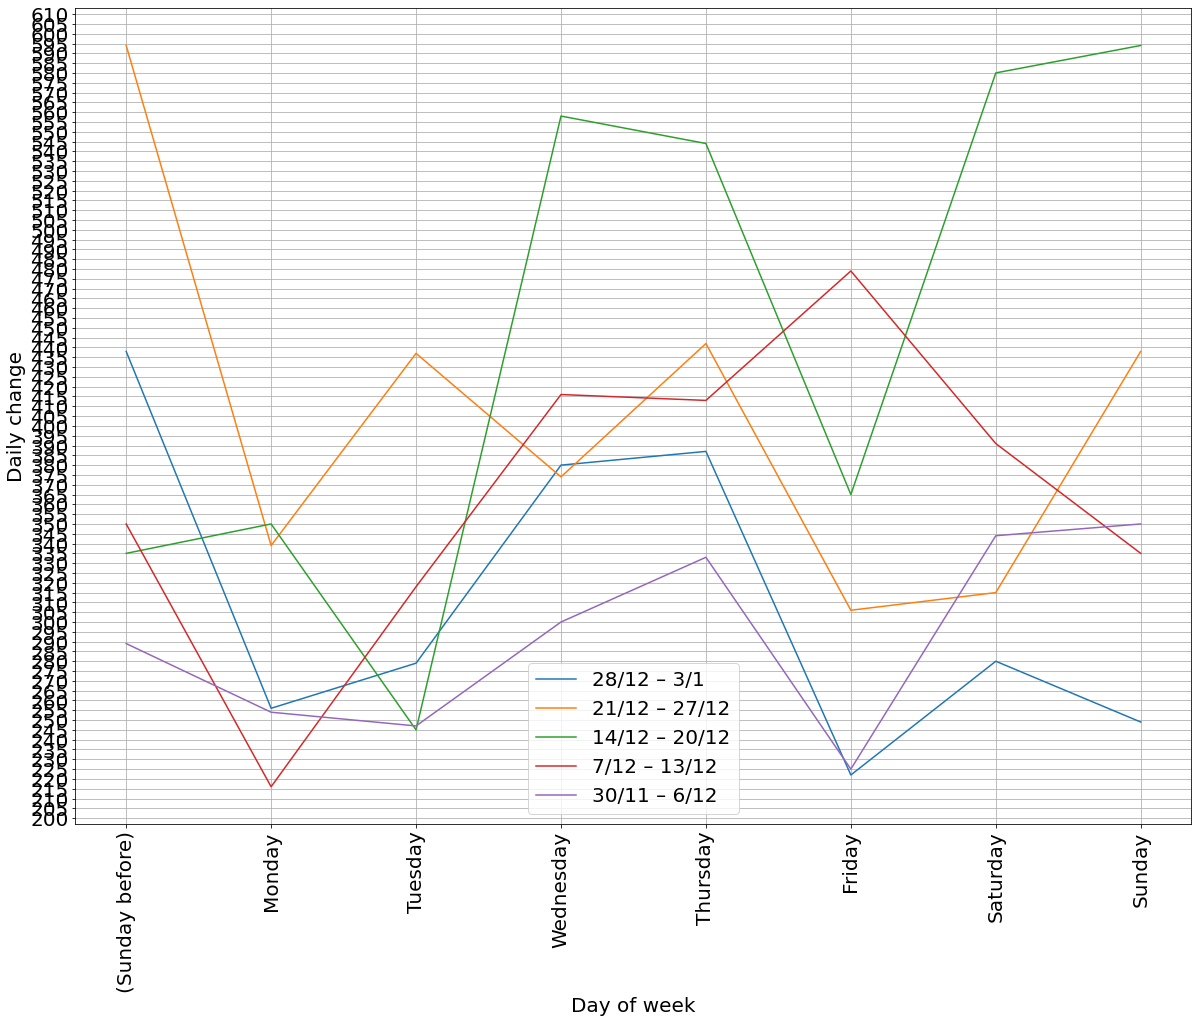

,Date_of_report,Week,Daily_delta,Total_reported
133502,2021-03-12,10,325,65845
133866,2021-03-13,10,217,66062
134230,2021-03-14,10,270,66332
134594,2021-03-15,11,163,66495
134958,2021-03-16,11,263,66758
135322,2021-03-17,11,260,67018
135686,2021-03-18,11,181,67199


In [6]:
plot_daily_delta_for_last_n_weeks(cumuldf, n=5)
plt.show()

cumuldf[["Date_of_report","Week","Daily_delta","Total_reported"]].tail(7)

In [7]:
def plot_weekly_delta_for_last_n_weeks(df:pd.DataFrame, n:int) -> typing.Dict[str,int]:
    """
    Returns a dict containing weekly delta for the last n weeks,
    like: {"Week n": int,"Week n-1": int, ...}
    """

    weekly_delta = {}
    for week in range(0,n):
        if df["Week"].max() < week:
            print(f"Week no. {df['Week'].max() - week} does not exist.")
            continue

        this_week_num = df["Week"].max() - week
        week_delta = df[df["Week"] == this_week_num]["Daily_delta"].sum()

        if this_week_num == 0:
            weekly_delta[f"Week {this_week_num}"] = 0
            continue
        else:
            weekly_delta[f"Week {this_week_num}"] = week_delta
            continue
    return weekly_delta



### Plot week-on-week reported cases

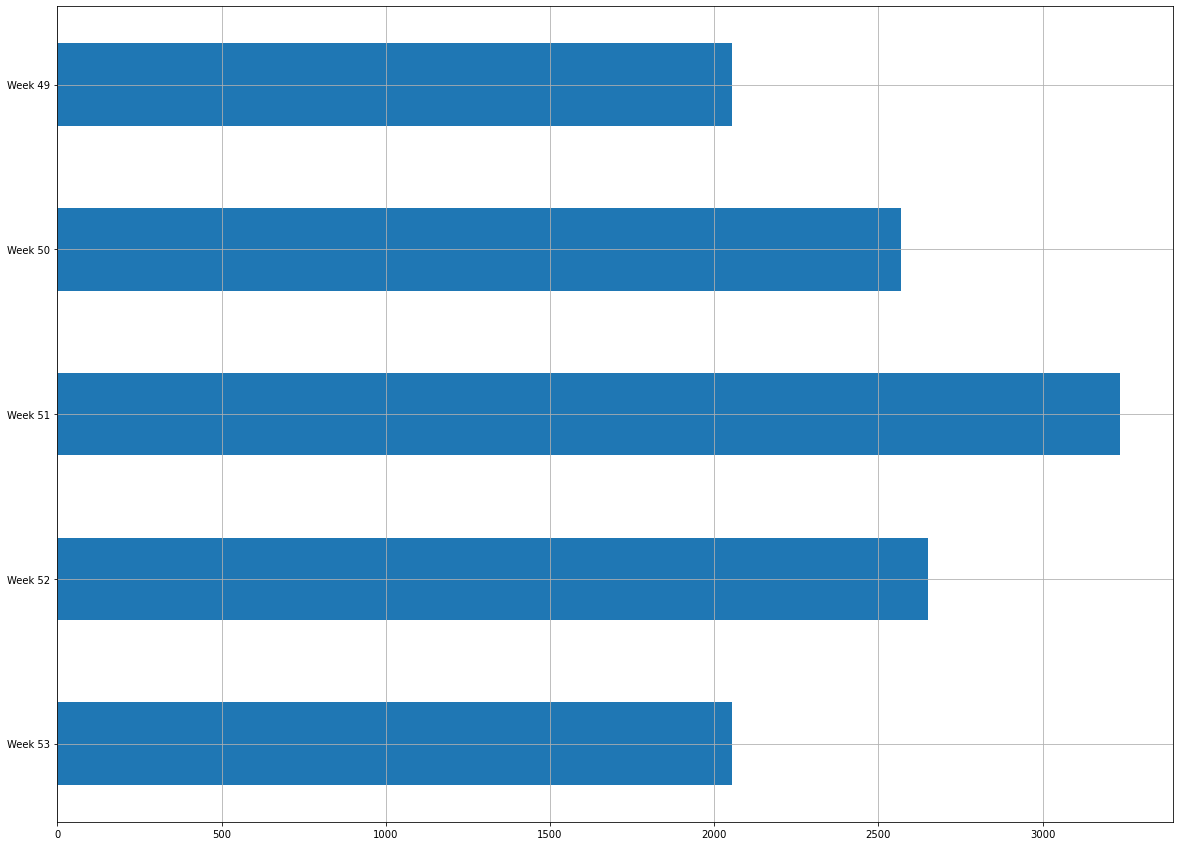

{'Week 49': 2053,
 'Week 50': 2568,
 'Week 51': 3236,
 'Week 52': 2651,
 'Week 53': 2053}


In [8]:
weekly_delta = plot_weekly_delta_for_last_n_weeks(cumuldf, 5)
plt.grid(True)
plt.barh(
    list(weekly_delta.keys()),
    width=np.array(list(weekly_delta.values())),
    height=0.5
)
plt.show()
pprint(weekly_delta)

In [9]:
# Helper function to plot last n days cumulative reported cases

def plot_cumul_reported_last_n_days(df:pd.DataFrame,n:int=3, col:str="Total_reported") -> None:
    plot_this = df.tail(n)
    plt.grid(True)
    plt.xticks(rotation="vertical", fontsize=_FONTSIZE)
    plt.yticks(plot_this[col], fontsize=_FONTSIZE)
    plt.plot_date(
        plot_this["Date_of_report"].loc[-n:,],
        plot_this[col],
        xdate=True
    )
    plt.show()
    pprint(df[["Date_of_report", col]].tail(n))

### Cumulative reported cases for the last 30 days

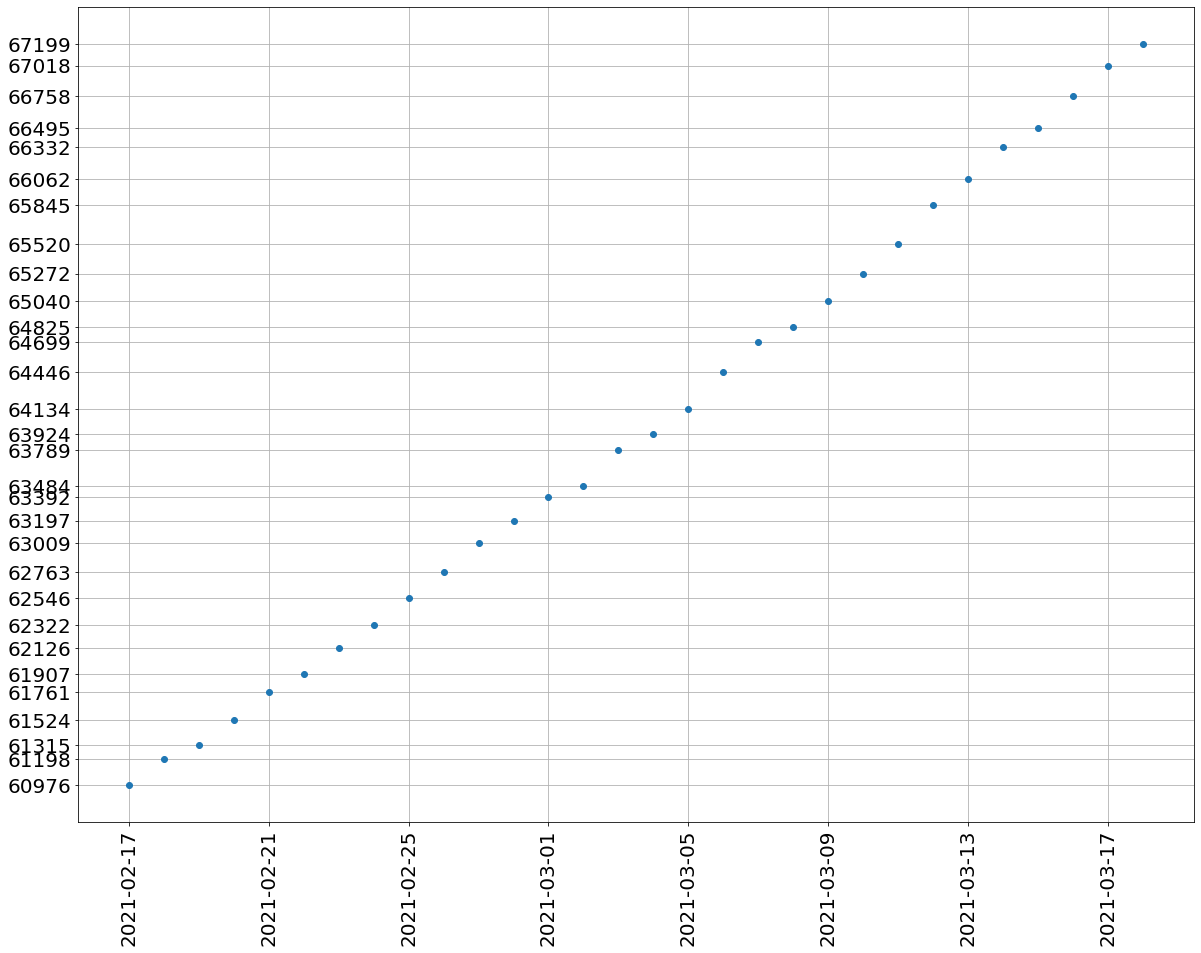

       Date_of_report  Total_reported
125130     2021-02-17           60976
125494     2021-02-18           61198
125858     2021-02-19           61315
126222     2021-02-20           61524
126586     2021-02-21           61761
126950     2021-02-22           61907
127314     2021-02-23           62126
127678     2021-02-24           62322
128042     2021-02-25           62546
128406     2021-02-26           62763
128770     2021-02-27           63009
129134     2021-02-28           63197
129498     2021-03-01           63392
129862     2021-03-02           63484
130226     2021-03-03           63789
130590     2021-03-04           63924
130954     2021-03-05           64134
131318     2021-03-06           64446
131682     2021-03-07           64699
132046     2021-03-08           64825
132410     2021-03-09           65040
132774     2021-03-10           65272
133138     2021-03-11           65520
133502     2021-03-12           65845
133866     2021-03-13           66062
134230     2

In [10]:
plot_cumul_reported_last_n_days(cumuldf, 30, "Total_reported")

### Cumulative reported cases since beginning

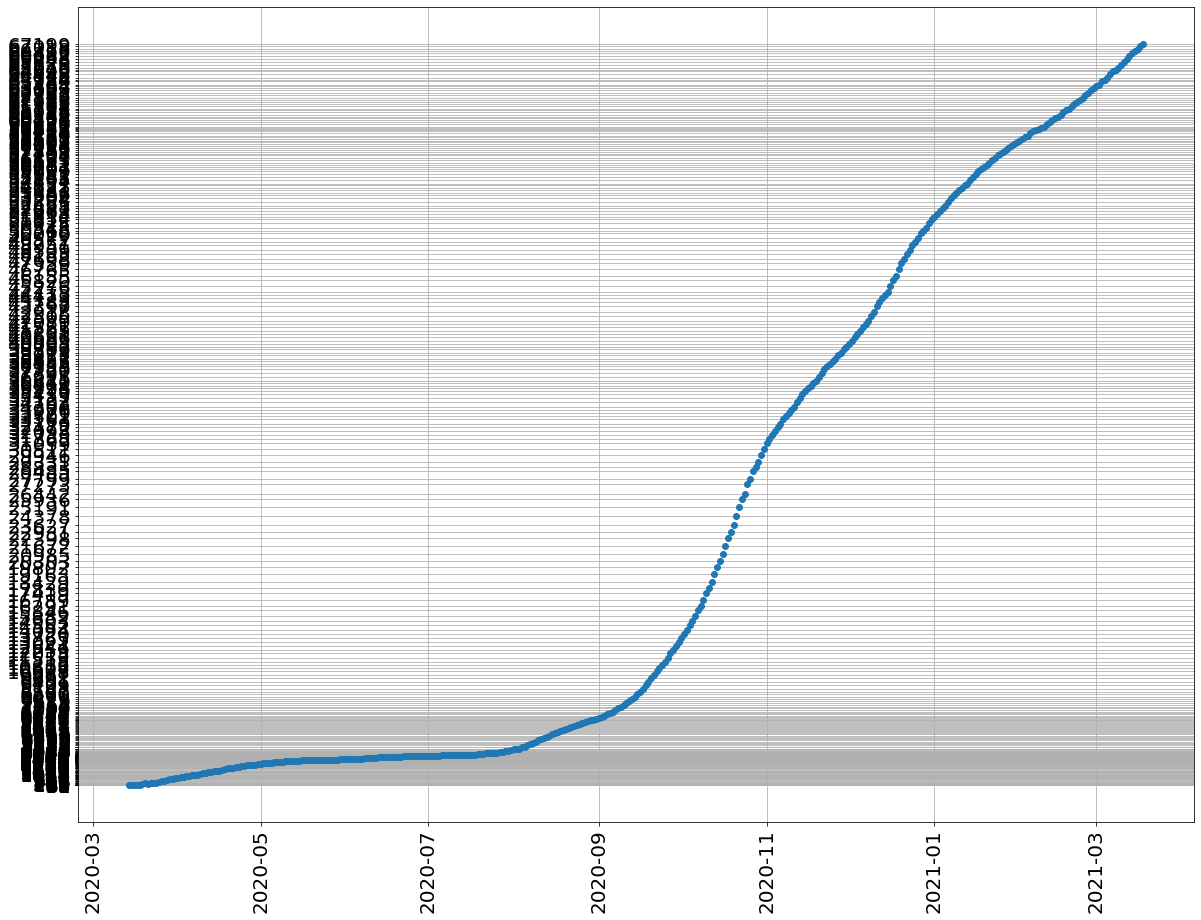

       Date_of_report  Total_reported
476        2020-03-14              31
843        2020-03-15              31
1210       2020-03-16              39
1577       2020-03-17              56
1944       2020-03-18              61
...               ...             ...
134230     2021-03-14           66332
134594     2021-03-15           66495
134958     2021-03-16           66758
135322     2021-03-17           67018
135686     2021-03-18           67199

[370 rows x 2 columns]


In [11]:
plot_cumul_reported_last_n_days(cumuldf, -1, "Total_reported")

### Cumulative hospitalizations for last 30 days

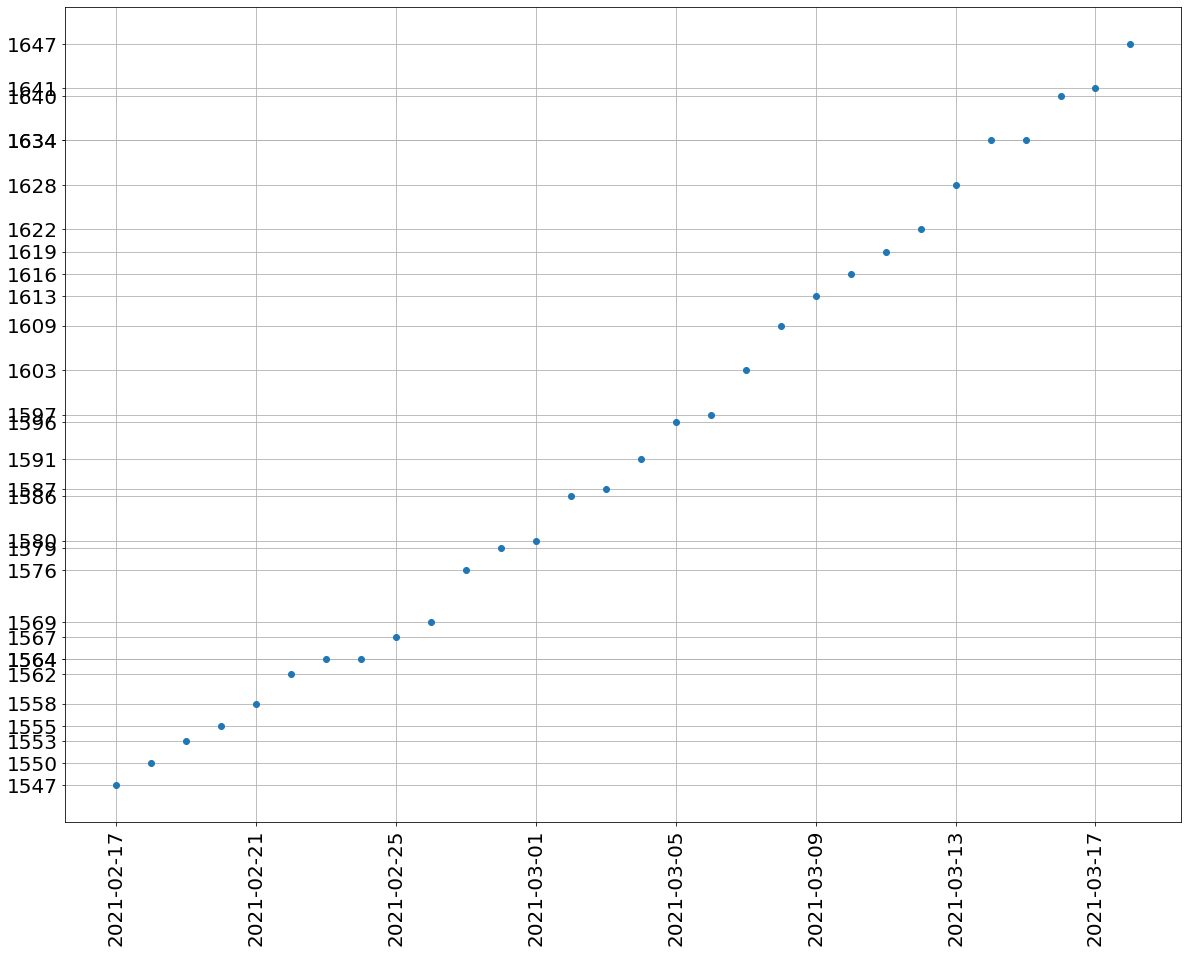

       Date_of_report  Hospital_admission
125130     2021-02-17                1547
125494     2021-02-18                1550
125858     2021-02-19                1553
126222     2021-02-20                1555
126586     2021-02-21                1558
126950     2021-02-22                1562
127314     2021-02-23                1564
127678     2021-02-24                1564
128042     2021-02-25                1567
128406     2021-02-26                1569
128770     2021-02-27                1576
129134     2021-02-28                1579
129498     2021-03-01                1580
129862     2021-03-02                1586
130226     2021-03-03                1587
130590     2021-03-04                1591
130954     2021-03-05                1596
131318     2021-03-06                1597
131682     2021-03-07                1603
132046     2021-03-08                1609
132410     2021-03-09                1613
132774     2021-03-10                1616
133138     2021-03-11             

In [12]:
plot_cumul_reported_last_n_days(cumuldf, 30, "Hospital_admission")

### Cumulative hospitalizations since beginning

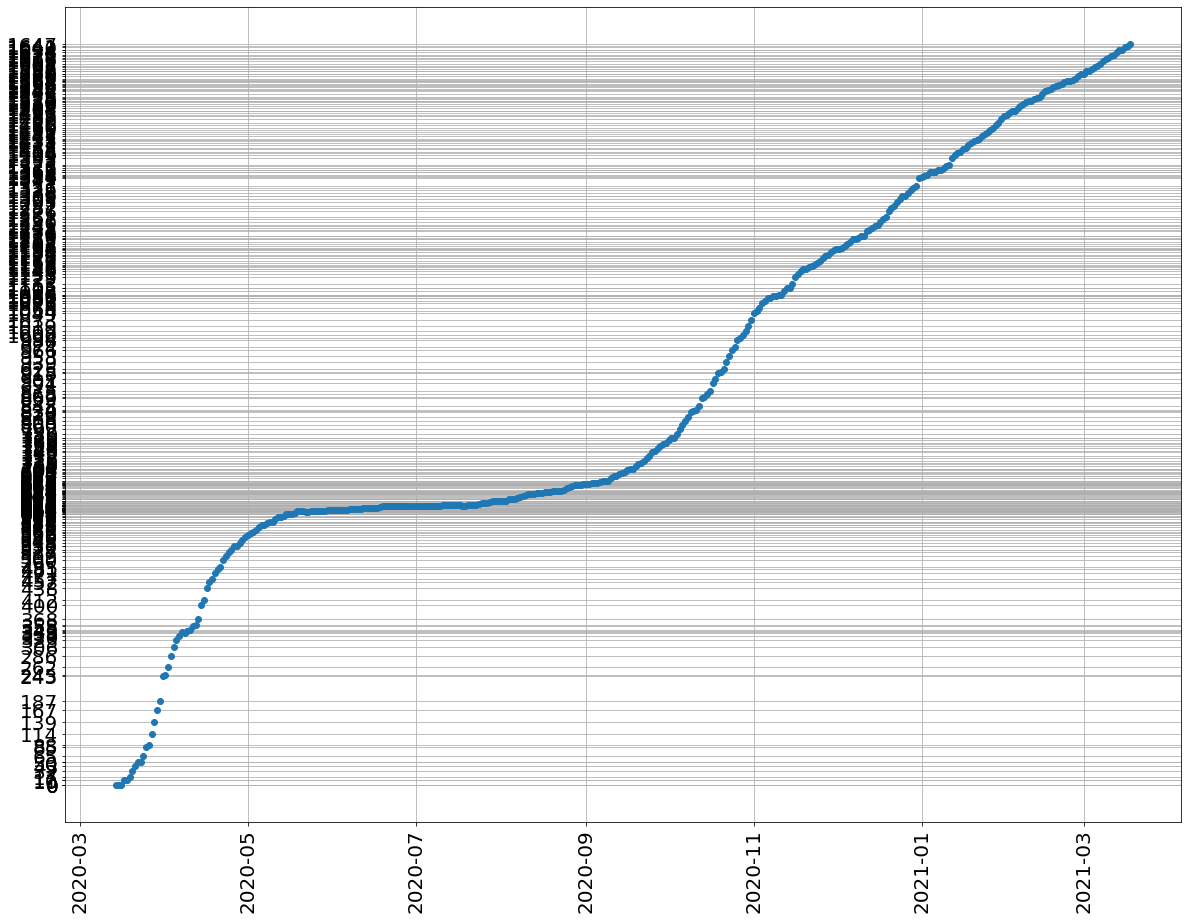

       Date_of_report  Hospital_admission
476        2020-03-14                   0
843        2020-03-15                   0
1210       2020-03-16                   0
1577       2020-03-17                  10
1944       2020-03-18                  11
...               ...                 ...
134230     2021-03-14                1634
134594     2021-03-15                1634
134958     2021-03-16                1640
135322     2021-03-17                1641
135686     2021-03-18                1647

[370 rows x 2 columns]


In [13]:
plot_cumul_reported_last_n_days(cumuldf, -1, "Hospital_admission")

### Cumulative deaths since beginning

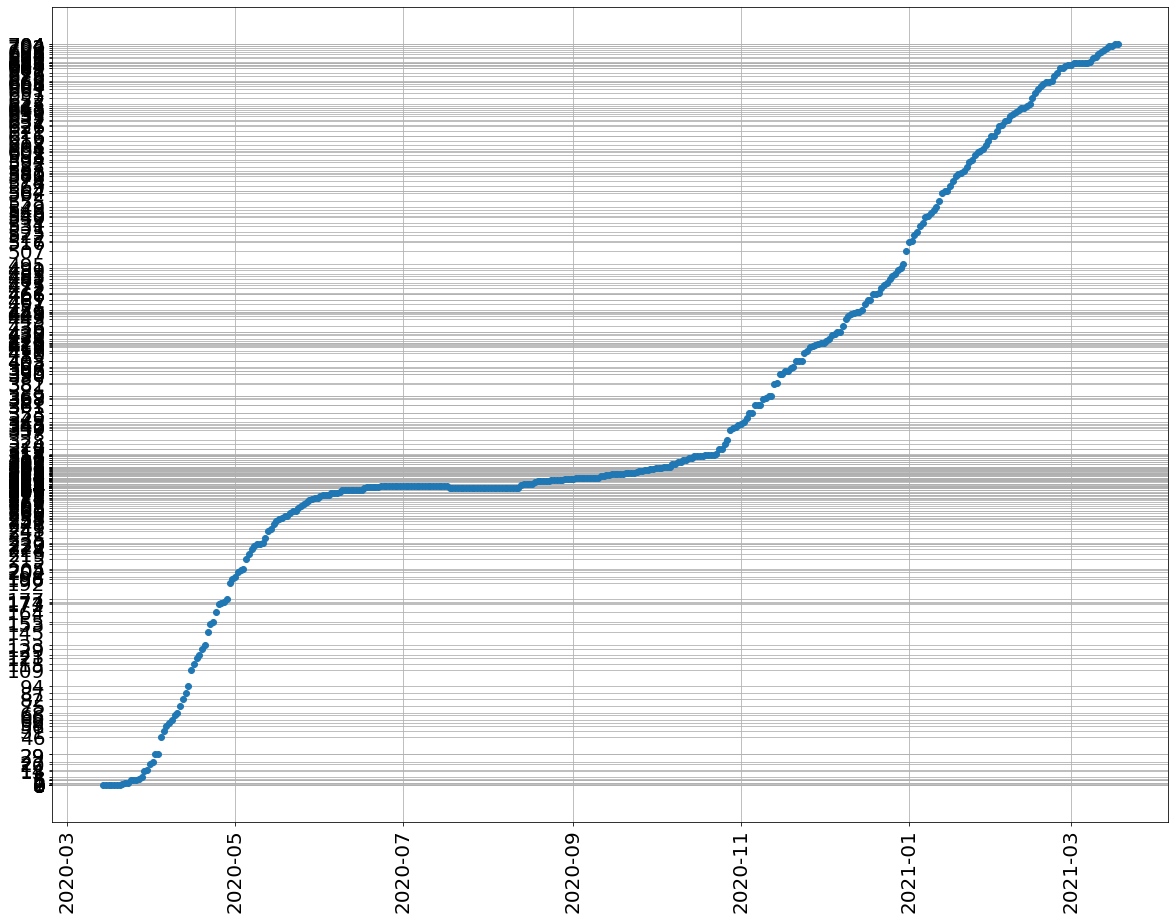

       Date_of_report  Deceased
476        2020-03-14         0
843        2020-03-15         0
1210       2020-03-16         0
1577       2020-03-17         0
1944       2020-03-18         0
...               ...       ...
134230     2021-03-14       700
134594     2021-03-15       702
134958     2021-03-16       702
135322     2021-03-17       704
135686     2021-03-18       704

[370 rows x 2 columns]


In [14]:
plot_cumul_reported_last_n_days(cumuldf, -1, "Deceased")